In [1]:
import warnings

warnings.filterwarnings("ignore")

import logging
import random

import anndata2ri
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rpy2.rinterface_lib.callbacks
import scanpy as sc
import seaborn as sns
from rpy2.robjects import pandas2ri

sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

In [113]:
%%R
library(edgeR)
library(limma)


# Read data from file

In [ ]:
adata = sc.read("../analysis_results/07_analysis.h5ad")

We can look at the counts of cell types in each sample to see which cell types have adequate sample sizes

In [4]:
pd.crosstab(adata.obs["celltypist_cell_label_coarse"], adata.obs["sample"])

sample,ETV6-RUNX1_1,ETV6-RUNX1_2,ETV6-RUNX1_3,PBMMC_1,PBMMC_2,PBMMC_3,PRE-T_1,PRE-T_2
celltypist_cell_label_coarse,,,,,,,,
B cells,144,285,177,30,48,191,9,47
B-cell lineage,1836,4974,1299,181,117,309,3,6
DC,0,0,0,15,51,57,0,6
Double-negative thymocytes,19,7,2,14,19,13,2291,947
Erythroid,7,6,3,8,1707,11,8,7
HSC/MPP,0,5,14,2,39,56,2,14
Monocytes,0,5,13,83,102,371,1,94
Plasma cells,0,0,1,0,10,0,0,0
Promyelocytes,0,0,0,16,30,81,0,12


Make a column with the condition of cells in each sample

In [5]:
condition = {
    "PBMMC_1": "healthy", 
    "PBMMC_2": "healthy", 
    "PBMMC_3": "healthy", 
    "PRE-T_1": "cancer_a", 
    "PRE-T_2": "cancer_a",
    "ETV6-RUNX1_1": "cancer_b",
    "ETV6-RUNX1_2": "cancer_b",
    "ETV6-RUNX1_3": "cancer_b"}

adata.obs["condition"] = adata.obs["sample"].map(condition)

Create a group column combining the sample id and the treatment condition. This will be useful later on.

In [6]:
adata.obs["group"] = [f"{rep}_{l}" for rep, l in zip(adata.obs["sample"], adata.obs["condition"])]

Create more easily typed cell type column and remove characters that will be problematic in R

In [7]:
adata.obs["cell_type"] = adata.obs["celltypist_cell_label_coarse"]
adata.obs["cell_type"] = [ct.replace(" ", "_") for ct in adata.obs["cell_type"]]
adata.obs["cell_type"] = [ct.replace("+", "") for ct in adata.obs["cell_type"]]

Set categorical metadata to category type

In [8]:
adata.obs["sample"] = adata.obs["sample"].astype("category")
adata.obs["condition"] = adata.obs["condition"].astype("category")
adata.obs["group"] = adata.obs["group"].astype("category")
adata.obs["cell_type"] = adata.obs["cell_type"].astype("category")


Set counts to the original raw counts

In [9]:
adata.X = adata.layers["counts"].copy()

Function for filtering donors and creating pseudo-replicates

In [10]:
NUM_OF_CELL_PER_DONOR = 30

def aggregate_and_filter(
    adata,
    cell_identity,
    donor_key="group",
    condition_key="condition",
    cell_identity_key="cell_type",
    obs_to_keep=None,  # which additional metadata to keep, e.g. gender, age, etc.
    replicates_per_patient=1,
):
    # subset adata to the given cell identity
    if obs_to_keep is None:
        obs_to_keep = []
    adata_cell_pop = adata[adata.obs[cell_identity_key] == cell_identity].copy()
    # check which donors to keep according to the number of cells specified with NUM_OF_CELL_PER_DONOR
    size_by_donor = adata_cell_pop.obs.groupby([donor_key]).size()
    donors_to_drop = [
        donor
        for donor in size_by_donor.index
        if size_by_donor[donor] <= NUM_OF_CELL_PER_DONOR
    ]
    if len(donors_to_drop) > 0:
        print("Dropping the following samples:")
        print(donors_to_drop)
    df = pd.DataFrame(columns=[*adata_cell_pop.var_names, *obs_to_keep])

    adata_cell_pop.obs[donor_key] = adata_cell_pop.obs[donor_key].astype("category")
    for i, donor in enumerate(donors := adata_cell_pop.obs[donor_key].cat.categories):
        print(f"\tProcessing donor {i+1} out of {len(donors)}...", end="\r")
        if donor not in donors_to_drop:
            adata_donor = adata_cell_pop[adata_cell_pop.obs[donor_key] == donor]
            # create replicates for each donor
            indices = list(adata_donor.obs_names)
            random.shuffle(indices)
            indices = np.array_split(np.array(indices), replicates_per_patient)
            for i, rep_idx in enumerate(indices):
                adata_replicate = adata_donor[rep_idx]
                # specify how to aggregate: sum gene expression for each gene for each donor and also keep the condition information
                agg_dict = {gene: "sum" for gene in adata_replicate.var_names}
                for obs in obs_to_keep:
                    agg_dict[obs] = "first"
                # create a df with all genes, donor and condition info
                df_donor = pd.DataFrame(adata_replicate.X.toarray())
                df_donor.index = adata_replicate.obs_names
                df_donor.columns = adata_replicate.var_names
                df_donor = df_donor.join(adata_replicate.obs[obs_to_keep])
                # aggregate
                df_donor = df_donor.groupby(donor_key).agg(agg_dict)
                df_donor[donor_key] = donor
                df.loc[f"donor_{donor}_{i}"] = df_donor.loc[donor]
    print("\n")
    # create AnnData object from the df
    adata_cell_pop = sc.AnnData(
        df[adata_cell_pop.var_names], obs=df.drop(columns=adata_cell_pop.var_names)
    )
    return adata_cell_pop

In [12]:
obs_to_keep = ["condition", "cell_type", "sample", "group"]

In [13]:
adata_pb = aggregate_and_filter(adata, cell_identity="T_cells", 
                                obs_to_keep=obs_to_keep, replicates_per_patient=2)

Dropping the following samples:
['ETV6-RUNX1_1_cancer_b']
	Processing donor 8 out of 8...



In [14]:
adata_pb

AnnData object with n_obs × n_vars = 14 × 17658
    obs: 'condition', 'cell_type', 'sample', 'group'

In [15]:
adata_pb.layers['counts'] = adata_pb.X.copy()

In [16]:
sc.pp.normalize_total(adata_pb, target_sum=1e6)
sc.pp.log1p(adata_pb)
sc.pp.pca(adata_pb)

In [17]:
adata_pb.obs["lib_size"] = np.sum(adata_pb.layers["counts"], axis=1)
adata_pb.obs["log_lib_size"] = np.log(np.float64(adata_pb.obs["lib_size"]))

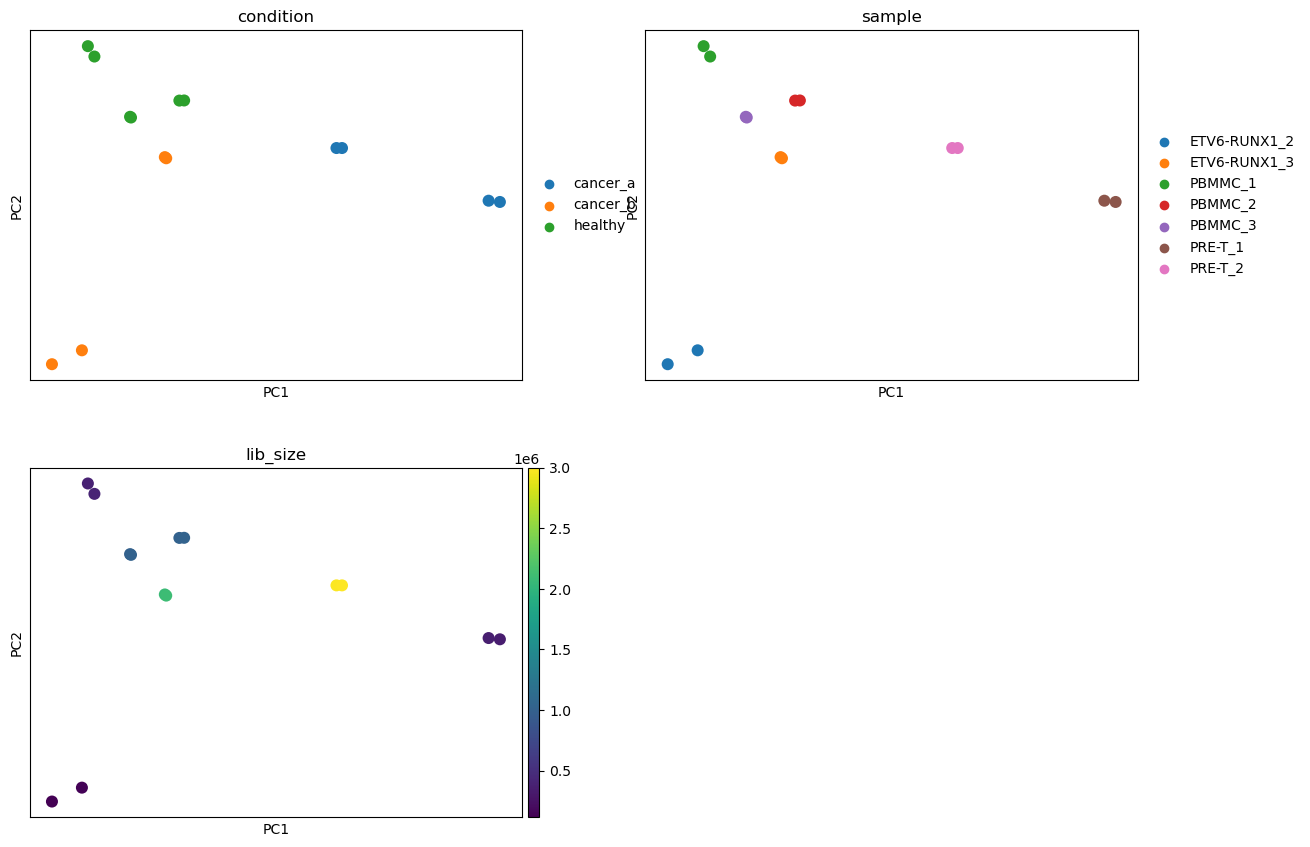

In [18]:
sc.pl.pca(adata_pb, color=["condition", "sample", "lib_size"], ncols=2, size=300)


Change back to raw since it is required by edgeR

In [19]:
adata_pb.X = adata_pb.layers['counts'].copy()

In [71]:
counts = adata_pb.X
genes = adata_pb.var_names.tolist()
samples = adata_pb.obs["sample"].tolist()
condition = adata_pb.obs["condition"].tolist()

In [ ]:
%%R -i counts -i samples -i genes -i condition

rownames(counts) <- genes
colnames(counts) <- samples

dge <- DGEList(counts = counts, 
               group = condition,
               remove.zeros = TRUE)

# filter out genes with low counts
print("Dimensions before subsetting:")
print(dim(dge))
print("")
keep <- filterByExpr(dge)
dge <- dge[keep, , keep.lib.sizes=FALSE]
print("Dimensions after subsetting:")
print(dim(dge))
print("")


dge <- calcNormFactors(dge)

design <- model.matrix(~0 + group, data=dge$samples)

y <- estimateDisp(dge, design=design)

fit <- glmQLFit(y, design)


[1] "Dimensions before subsetting:"
[1] 8867   14
[1] ""
[1] "Dimensions after subsetting:"
[1] 8867   14
[1] ""


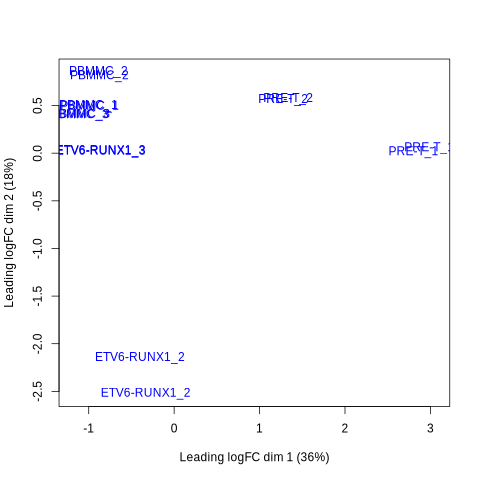

In [102]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "stim", "red", "blue"))

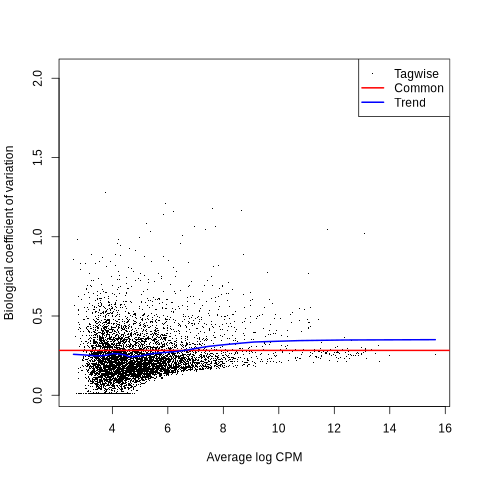

In [103]:
%%R
plotBCV(y)

In [104]:
%%R 
colnames(y$design)

[1] "groupcancer_a" "groupcancer_b" "grouphealthy" 


In [105]:
%%R 
contrasts <- makeContrasts(
    healthy_vs_cancer = grouphealthy - (groupcancer_a + groupcancer_b)/2,
    cancer_a_vs_cancer_b = groupcancer_a - groupcancer_b,
    levels=colnames(design))

In [106]:
%%R -o tt

qlf <- glmQLFTest(fit, contrast=contrasts)

# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table

In [118]:
%%R 
results <- decideTests(qlf)
summary(results)

     [,1]
[1,] 5584
[2,] 3283


In [107]:
tt[:5]

,logFC.healthy_vs_cancer,logFC.cancer_a_vs_cancer_b,logCPM,F,PValue,FDR
MYO7B,-6.504186,6.207328,6.472182,302.796728,2.085739e-14,1.849425e-10
CASC15,-5.204915,6.252945,7.077710,227.557895,2.401420e-13,1.064669e-09
TPO,-3.430737,10.278856,5.556794,289.352692,1.598717e-12,4.725275e-09
SOX4,-2.064771,4.595820,8.937584,171.945292,2.573386e-12,4.927840e-09
LPAR6,-2.357235,2.268639,6.682848,167.019763,3.285419e-12,4.927840e-09


In [108]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])


Error in plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR < 0.01)]) : 
  table$logFC slot in DGELRT object is NULL. We cannot produce an MA (smear) plot if more than one coefficient from the GLM is being tested in the likelihood ratio test as this results in more one logFC value per gene---one for each coefficient.


RInterpreterError: Failed to parse and evaluate line 'plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR<0.01)])\n'.
R error message: 'Error in plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR < 0.01)]) : \n  table$logFC slot in DGELRT object is NULL. We cannot produce an MA (smear) plot if more than one coefficient from the GLM is being tested in the likelihood ratio test as this results in more one logFC value per gene---one for each coefficient.'